# 3.11 模型选择、欠拟合和过拟合


## 3.11.4 多项式函数拟合实验

In [20]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 3.11.4.1 生成数据集

In [21]:
# 设置训练集和测试集的大小，以及真实的权重和偏置
n_train, n_test = 100, 100
true_w = [1.2, -3.4, 5.6]
true_b = 5

# 生成特征
features = tf.random.normal(shape=(n_train + n_test, 1))

# 创建多项式特征
poly_features = tf.concat([
    features,
    tf.pow(features, 2),
    tf.pow(features, 3)
], axis=1)

# 计算标签
labels = (true_w[0] * poly_features[:, 0] + 
          true_w[1] * poly_features[:, 1] + 
          true_w[2] * poly_features[:, 2] + 
          true_b)

# 添加噪声
labels += tf.random.normal(labels.shape, stddev=0.1)

看一看生成的数据集的前两个样本。

In [22]:
features[:2], poly_features[:2], labels[:2]

(<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
 array([[-1.4763564],
        [-1.3549409]], dtype=float32)>,
 <tf.Tensor: shape=(2, 3), dtype=float32, numpy=
 array([[-1.4763564,  2.1796281, -3.2179081],
        [-1.3549409,  1.8358648, -2.4874883]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-22.112381, -16.71607 ], dtype=float32)>)

### 3.11.4.2. 定义、训练和测试模型¶

In [23]:
from IPython import display
def use_svg_display():
    """Use svg format to display plot in jupyter"""
    display.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """Set matplotlib figure size."""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

In [24]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None,
             legend=None, figsize=(3.5, 2.5)):
    set_figsize(figsize)
    from matplotlib import font_manager
    # 设置中文字体
    plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
    plt.rcParams['axes.unicode_minus'] = False  # 使用 ASCII 减号
    
    # 为轴标签设置字体
    font_prop = font_manager.FontProperties(family='Arial Unicode MS')
    
    plt.xlabel(x_label, fontproperties=font_prop)
    plt.ylabel(y_label, fontproperties=font_prop)
    plt.semilogy(x_vals, y_vals)
    
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        if legend:
            plt.legend(legend, prop=font_prop)
    
    plt.show()

和线性回归一样，多项式函数拟合也使用平方损失函数。因为我们将尝试使用不同复杂度的模型来拟合生成的数据集，所以我们把模型定义部分放在fit_and_plot函数中。多项式函数拟合的训练和测试步骤与3.6节（softmax回归的从零开始实现）介绍的softmax回归中的相关步骤类似。

In [25]:
num_epochs, loss = 100, tf.losses.MeanSquaredError()

def fit_and_plot(train_features, test_features, train_labels, test_labels):
    net = tf.keras.Sequential()
    net.add(tf.keras.layers.Dense(1))
    batch_size = min(10, train_labels.shape[0])
    train_iter = tf.data.Dataset.from_tensor_slices(
        (train_features, train_labels)).batch(batch_size)
    test_iter = tf.data.Dataset.from_tensor_slices(
        (test_features, test_labels)).batch(batch_size)
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            with tf.GradientTape() as tape:
                l = loss(y, net(X))

            grads = tape.gradient(l, net.trainable_variables)
            optimizer.apply_gradients(zip(grads, net.trainable_variables))

        train_ls.append(loss(train_labels, net(train_features)).numpy().mean())
        test_ls.append(loss(test_labels, net(test_features)).numpy().mean())
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss',
             range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.get_weights()[0],
          '\nbias:', net.get_weights()[1])

### 3.11.4.3. 三阶多项式函数拟合（正常）¶

final epoch: train loss 0.0088772895 test loss 0.009899671


/var/folders/35/vdx84dbd0rbbtkdzkscy9ly80000gn/T/ipykernel_17829/2538575514.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


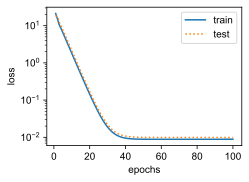

weight: [[ 1.2019234]
 [-3.3986826]
 [ 5.6023893]] 
bias: [5.00176]


In [26]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :],
             labels[:n_train], labels[n_train:])

### 3.11.4.4. 线性函数拟合（欠拟合）¶

final epoch: train loss 190.61496 test loss 226.90633


/var/folders/35/vdx84dbd0rbbtkdzkscy9ly80000gn/T/ipykernel_17829/2538575514.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


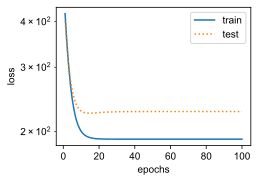

weight: [[18.525166]] 
bias: [3.1586561]


In [27]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train],
             labels[n_train:])

### 3.11.4.5. 训练样本不足（过拟合）

final epoch: train loss 0.631154 test loss 77.03858


/var/folders/35/vdx84dbd0rbbtkdzkscy9ly80000gn/T/ipykernel_17829/2538575514.py:4: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


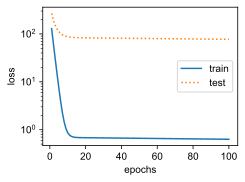

weight: [[ 1.7114376]
 [-3.1233697]
 [ 3.468374 ]] 
bias: [-0.90314865]


In [28]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2],
             labels[n_train:])